In [1]:
import torch
import torch.nn.functional as F
import gc
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from supervoice_separate.model import SeparateModel 
from supervoice_separate.audio import load_mono_audio, spectogram
from supervoice_separate.config import config
from training.dataset import load_mixed_sampler

In [2]:
sampler = load_mixed_sampler(["./external_datasets/hifi-tts/audio"], 5)

# Model
device = "cuda:1"
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
flow = torch.hub.load(repo_or_dir='ex3ndr/supervoice-flow', model='flow')
checkpoint = torch.load(f'./output/ft-02.pt', map_location="cpu")
enhance = SeparateModel(flow, config)
enhance.load_state_dict(checkpoint['model'])
enhance.to(device)
enhance.eval()
vocoder.to(device)
vocoder.eval()
print("OK")

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master
Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-flow_main


OK


In [3]:
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src.T.unsqueeze(0)).squeeze(0)

def do_enhance(src, steps = 8):
    with torch.no_grad():
        src = (src - config.audio.norm_mean) / config.audio.norm_std
        pr = enhance.sample(source = src.to(torch.float32), steps = steps)
        return ((pr * config.audio.norm_std) + config.audio.norm_mean).to(torch.float32)

def do_flow(src, steps = 8):
    with torch.no_grad():
        src = (src - config.audio.norm_mean) / config.audio.norm_std
        pr, _ = direct_flow.sample(audio = src.to(torch.float32), steps = steps)
        return ((pr * config.audio.norm_std) + config.audio.norm_mean).to(torch.float32)

def do_distort(src):
    return pipeline.apply(src, config.audio.sample_rate)

In [4]:
source, distorted = sampler()
source_rec = do_vocoder(source.to(device).to(torch.float32))
distorted_rec = do_vocoder(distorted.to(device).to(torch.float32))
display(Audio(data=source_rec.cpu(), rate=config.audio.sample_rate))
display(Audio(data=distorted_rec.cpu(), rate=config.audio.sample_rate))

In [5]:
source_sep = do_enhance(source.to(device), 8)
distorted_sep = do_enhance(distorted.to(device), 8)
diff_sep = distorted_sep.cpu() - distorted.cpu()
source_sep_rec = do_vocoder(source_sep.to(device))
distorted_sep_rec = do_vocoder(distorted_sep.to(device))
diff_sep_rec = do_vocoder(diff_sep.to(device))
display(Audio(data=source_sep_rec.cpu(), rate=config.audio.sample_rate))
display(Audio(data=distorted_sep_rec.cpu(), rate=config.audio.sample_rate))
display(Audio(data=diff_sep_rec.cpu(), rate=config.audio.sample_rate))

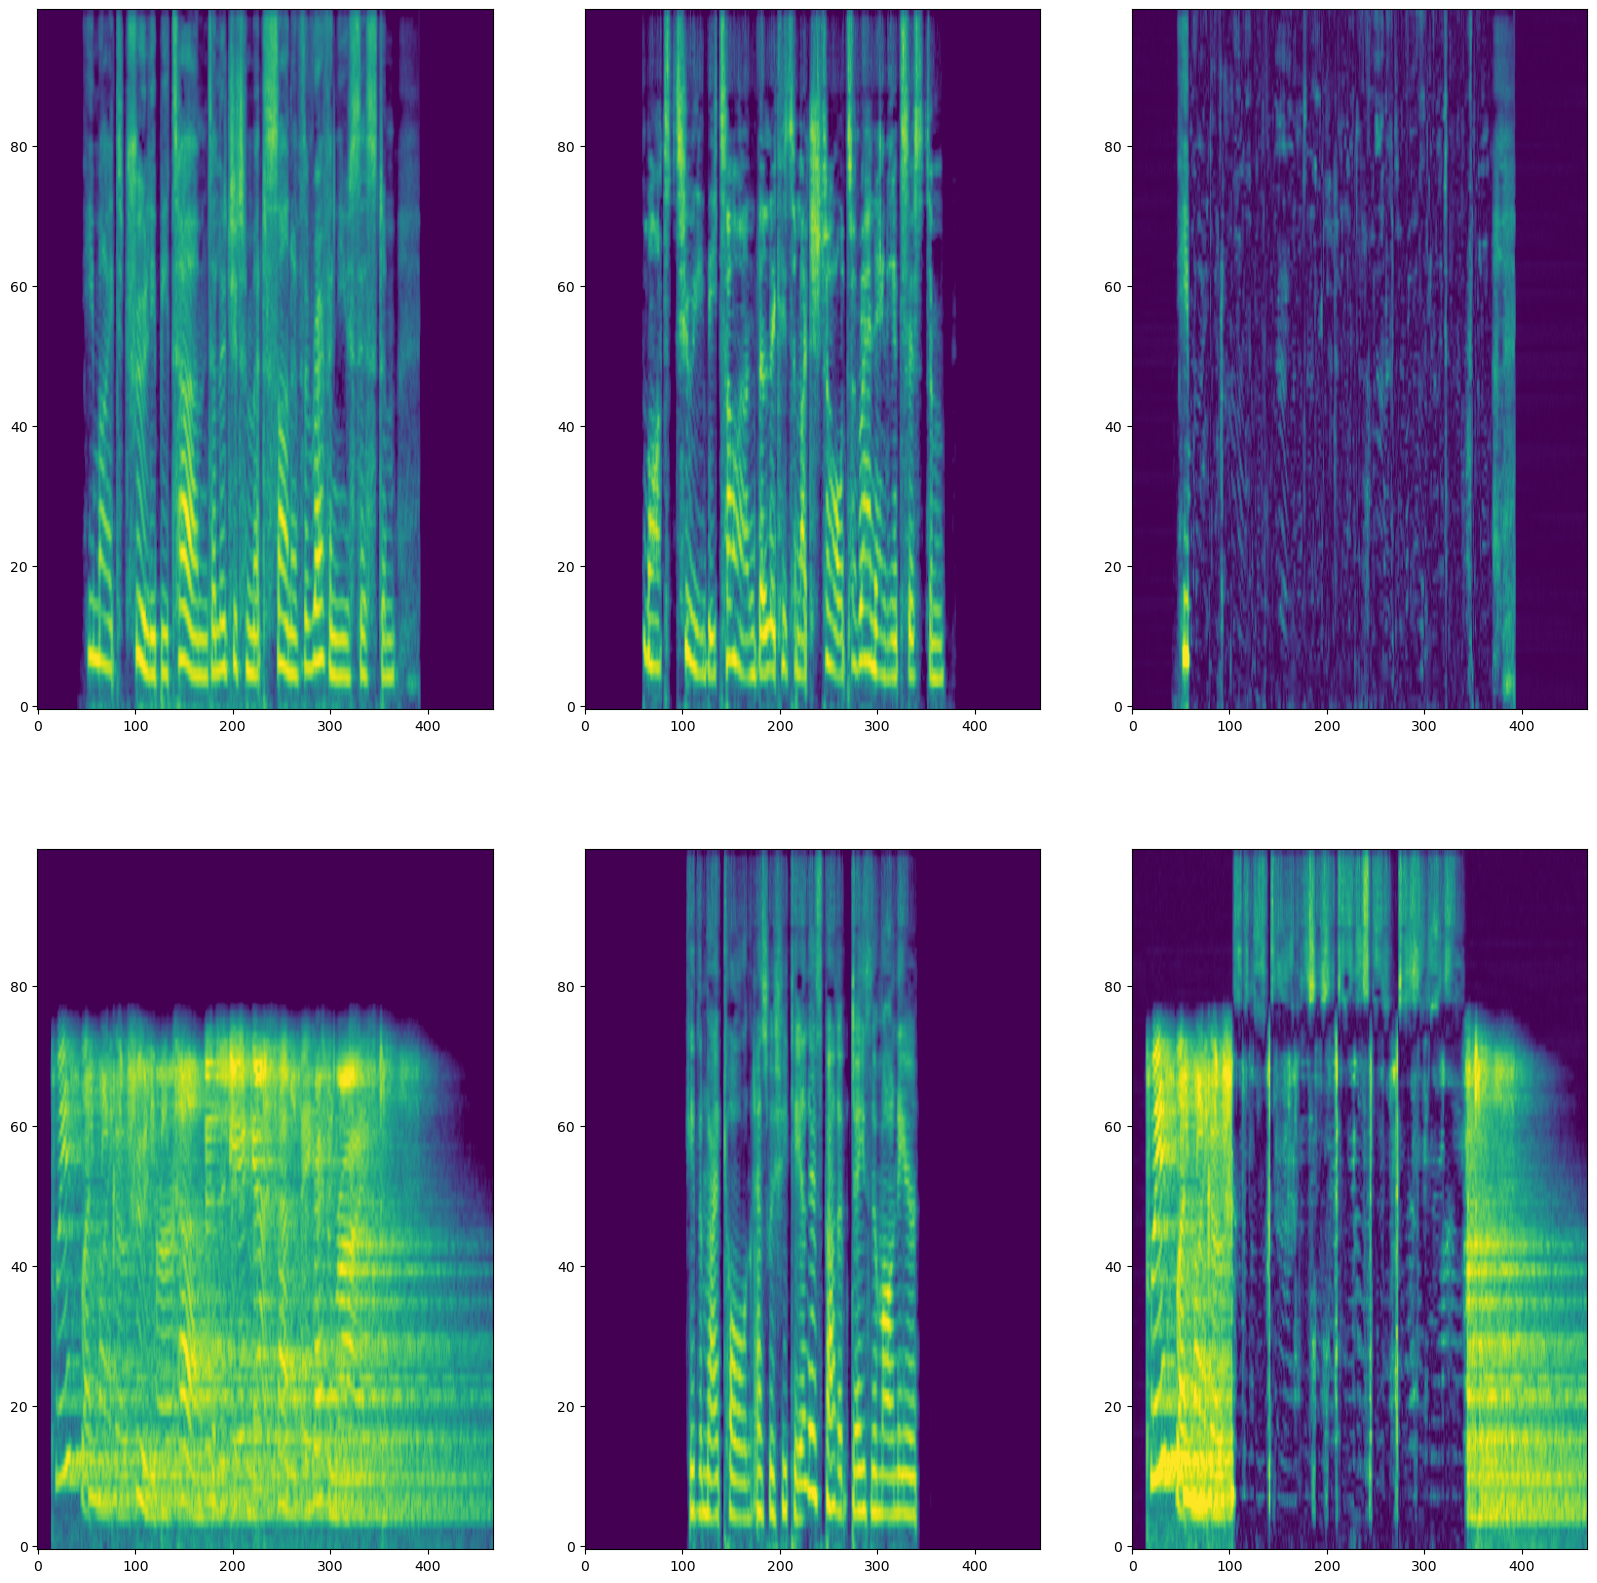

In [6]:
_, ax = plt.subplots(2, 3, figsize=(20, 20))
ax[0][0].imshow(source.T, vmin=-10, vmax=0, origin="lower", aspect="auto") # Original
ax[0][1].imshow(source_sep.T.cpu().squeeze(0), vmin=-10, vmax=0, origin="lower", aspect="auto") # Enhanced Original  
ax[0][2].imshow((source.T - source_sep.T.cpu().squeeze(0)).abs(), vmin=0, vmax=10, origin="lower", aspect="auto")
ax[1][0].imshow(distorted.T, vmin=-10, vmax=0, origin="lower", aspect="auto") # Distorted
ax[1][1].imshow(distorted_sep.T.cpu().squeeze(0), vmin=-10, vmax=0, origin="lower", aspect="auto") # Enhanced
ax[1][2].imshow((distorted.T - distorted_sep.T.cpu().squeeze(0)).abs(), vmin=0, vmax=10, origin="lower", aspect="auto")